# Criando um MDE e adicionando vetores de vento

Neste notebook eu crio um modelo digital de elevação a partir de um SRTM obtido pelo site: https://earthexplorer.usgs.gov/ e junto a elevação eu adiciono vetores de vento criados a partir de um arquivo netcdf(ERA5).

Robson Barreto dos Passos - Aluno de graduação em ciências atmosféricas - UNIFEI
robsonbarretodospassos@gmail.com

In [4]:
from osgeo import gdal #Importando o módulo osgeo para abrir o arquivo .tiff

In [5]:
filepath = "input/Itumbiara_TIF.tif"  #Definindo o caminho para o arquivo .tif

# Abrindo o arquivo:
raster = gdal.Open(filepath)

# Checando o tipo da variável Raster'
type(raster)

osgeo.gdal.Dataset

In [6]:
# Projeção
print(raster.GetProjection())
print(" ")

# Dimensões
print(raster.RasterXSize)
print(raster.RasterYSize)
print(" ")

# Numero de bandas
print(raster.RasterCount)
print(" ")

# Metadados do arquivo raster
print(raster.GetMetadata())
print(" ")

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.2572235604902,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
 
7201
7201
 
1
 
{'AREA_OR_POINT': 'Point', 'TIFFTAG_MAXSAMPLEVALUE': '1048', 'TIFFTAG_MINSAMPLEVALUE': '378'}
 


## Lendo dados do arquivo raster como uma matriz numérica 

In [7]:
from osgeo import gdal_array
import numpy as np

In [8]:
data = raster.ReadAsArray() # Lendo como uma matriz numerica

x0, dx, dxdy, y0, dydx, dy = raster.GetGeoTransform() #Isso servirá para definir as lats e lons

nrows, ncols = data.shape  #Obtendo o numero de linhas e colunas da matriz

In [9]:
# Gerando arrays para longitude e latitude
londata = np.linspace(x0, x0+dx*ncols, ncols)
latdata = np.linspace(y0, y0+dy*nrows, nrows)

lon, lat = np.meshgrid(londata, latdata) # Fazendo um grid de lat e lon paraos dados de elevação

print(latdata.shape, londata.shape) #Bate com o número de linhas e colunas da array ;)

(7201,) (7201,)


## Abrindo o arquivo netcdf (ERA5) com as componentes u e v do vento

In [10]:
import xarray as xr #Módulo array para trabalhar com o arquivo netcdf

#era5 = xr.open_dataset('E5_file1_teste.nc')[['u', 'v']].isel(time=0, level=0)

era5 = xr.open_dataset('input/itumbiara_u_v.nc')[['u', 'v']].isel(time=0).sel(level=850) #time índice 0 e level de 850 hPa
era5

<xarray.Dataset>
Dimensions:    (latitude: 9, longitude: 9)
Coordinates:
    level      int32 850
  * latitude   (latitude) float32 -17.0 -17.25 -17.5 ... -18.5 -18.75 -19.0
    time       datetime64[ns] 2008-01-01T12:00:00
  * longitude  (longitude) float32 -50.0 -49.75 -49.5 ... -48.5 -48.25 -48.0
Data variables:
    u          (latitude, longitude) float32 ...
    v          (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-03-13 21:51:49 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [11]:
x, y = np.meshgrid(era5['longitude'], era5['latitude']) #Criando um grid x, y a partir das latitudes e lomgitudes

u = era5.u # extraindo a componente zonal do vento
v = era5.v # extraindo a componente meridional dp vento

## Plotando a elevação e os vetores

### Para isso usarei cartopy e matplotlib 

In [12]:
# Importando os módulos necessários
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

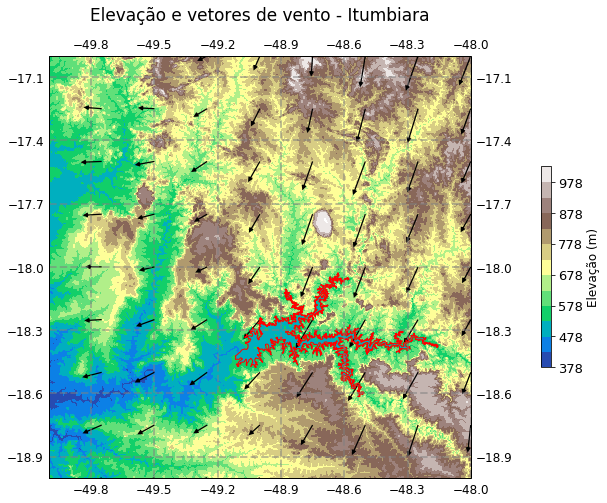

In [13]:
plt.figure(figsize=(9, 9)) #Criando a caixa de figura

ax = plt.axes(projection=ccrs.PlateCarree()) #definindo a projeção
extent = [londata.min(), londata.max(), latdata.max(), latdata.min()] 
ax.set_extent(extent) # Definindo a extensão do mapa

#================================================================================================
#Criando o mapa de elevação, com cores a cada intervalo de 50 metros
im = ax.contourf(lon, lat, data, cmap = "terrain", 
                 levels = list(range(data.min(), data.max(), 50)))

#================================================================================================
#Adicionando barra de cor
cbar = plt.colorbar(im, ax=ax, extend="both", shrink=0.5, aspect=20, fraction=0.02, pad=0.14)
cbar.set_label('Elevação (m)',size=12) #legenda da colorbar 
cbar.ax.tick_params(labelsize=13) # tamanho da legenda dos ticks

#================================================================================================
#Adicionando Shaperfile de todos os Reservatórios do Brasil
#all_shape = list(shpreader.Reader('Massas de água Brasil/geoft_bho_massa_dagua.shp').geometries())

#ax.add_geometries(all_shape, ccrs.PlateCarree(), edgecolor='black',
#                  facecolor='none')

#================================================================================================
#Adicionando Shaperfile do Reservatório de Itumbiara:
itumbiara_shape = list(shpreader.Reader('shp/Itumbiara/Itumbiara.shp').geometries())

ax.add_geometries(itumbiara_shape, ccrs.PlateCarree(), edgecolor='red',
                  facecolor='none')

#================================================================================================
#Adicionando os vetores de vento
ax.quiver(x, y, u, v, width =0.003, headwidth=4, headlength=4, transform=ccrs.PlateCarree())

#================================================================================================
# Adicionando título 
plt.title("Elevação e vetores de vento - Itumbiara",fontsize=17, y=1.07)

#================================================================================================
# Adicionando legenda e grid dos eixos
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = True
gl.ylabels_left = True
gl.xlines = True
gl.xlabel_style = {'size': 12, 'color': 'black', 'weight': 'normal'}
gl.ylabel_style = {'size': 12,'color': 'black', 'weight': 'normal'}

plt.savefig('images/itumbiara_850.png')